# Step3 演習02 ロジスティック回帰
---

Step3 演習02ではロジスティック回帰の実装を行います。

演習の前半は線形分離できるデータを扱います。

後半は線形分離が難しいデータを用いてモデルの学習を行い実際に分類することができるのか確認をします。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での使用は避けてください。

**本演習の目的**
- ロジスティック回帰の実装手順を学ぶ。
- 線形分離できるデータと線形分離ができないデータに対しての実装方法を学ぶ。
- 多項式で特徴を増やしてみる。
- オーバーフィッティング対策の一つであるL2正則化を実装する。
- SciPyを使った最適化手法に取り組む。

## ライブラリのインポート

まずはじめに、利用するライブラリのインポートを行います。

- [numpy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント
- [SciPy](https://docs.scipy.org/doc/) 数値解析ライブラリの基本パッケージの公式ドキュメント

ドキュメントには有用な情報が書き記されています。何か迷ったときには必ずドキュメントに戻ってくるようにしましょう。

次のセルをそのまま実行（"SHIFT" + "ENTER"）してください。コードが書いてあるセルは**上から順番に**順次実行してください。

** 注意： **初めてmatplotlibを使うユーザーは、フォント一覧のキャッシュが存在しないため、このセルの実行でWarningが出ます。もう一度実行すると、すでにキャッシュができているので、Warningなく走ります。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as scopt
import scipy.special as ss
from sklearn import datasets
import os
font = {'family':'IPAexGothic'}
plt.rc('font', **font)

## ロジスティック回帰に使うサンプルデータを生成

今回の演習では、事前に用意したデータセットを使ってロジスティック回帰の実装を行います。下のセルを実行するとデータセットが読み込まれます。一度生成したら同じものを毎回使えるように、データをCSVファイル(Comma-Separated Values コンマで区切られたデータ)で保存しておきます。
<br><br>
** Note： **新たなデータを使いたいときは、CSVファイルの名前を変えるか、コードを変えましょう。

In [2]:
if not os.path.isdir("./dataStep3"):
    os.makedirs("./dataStep3")

if os.path.isfile("./dataStep3/dataStep3_1.csv") == True:
    data = np.loadtxt("./dataStep3/dataStep3_1.csv", delimiter = ",")
    X = data[:,0:2]  # X.shapeは(100, 2)
    y = data[:,2] #y.shapeは(100, ) 1-dimのndarrayにしておく（縦ベクトルにならないこと注意）

else:
    X, y = datasets.make_classification(n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1)
    X = X * 12.5 + 50 # -4から4くらいから0から100くらいに変える
    np.savetxt("./dataStep3/dataStep3_1.csv", np.c_[X, y], delimiter=",", fmt="%f,%f,%d")

上のセルを実行したことによりデータセットを "data" に格納しました。下のセルを実行して、dataのshapeを確認しましょう。

In [3]:
data.shape

(100, 3)

(100,3)と表示されたはずです。
<br>
<br>
今回使うデータセットは100行3列の行列がdataに格納されています。そしてXにdataの2列目までのデータセットを格納し、yにdataの3列目のデータを格納しています。下のセルを実行して、格納したdataの中身の一部分を確認してみましょう。

部分的にdataの中身を確認する方法を知っていると便利です。下のセルを実行してみてください。

In [4]:
data[:5]

array([[24.852293, 53.636441,  0.      ],
       [63.063442, 55.237786,  1.      ],
       [62.893502, 74.363114,  1.      ],
       [39.334297, 56.22864 ,  0.      ],
       [63.390393, 76.889652,  1.      ]])

In [5]:
data[:5,0][:,np.newaxis]

array([[24.852293],
       [63.063442],
       [62.893502],
       [39.334297],
       [63.390393]])

In [6]:
data[:5,1][:,np.newaxis]

array([[53.636441],
       [55.237786],
       [74.363114],
       [56.22864 ],
       [76.889652]])

In [7]:
data[:5,2][:,np.newaxis]

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.]])

ここではdataの中身を訓練データ X と目標変数 y にわけました。** X **と ** y ** のデータを改めてshapeで確認しておきましょう。

In [8]:
X.shape

(100, 2)

In [9]:
y.shape

(100,)

In [ ]:
y

- ** X ** は訓練データ
- ** y ** は目標変数

## データセットの可視化

### 生成したデータの表示

可視化は機械学習の実装において大変重要な作業になります。開発を進める前にデータセットの性質を把握し、可視化する癖をつけておきましょう。

今回利用するデータセットの横軸は「声の大きさ」、縦軸は「話を面白いと感じた人数」とします。これら２つの特徴から「合格」、「不合格」という分類を行いたいとします。

**【課題８】** 可視化する関数plotData(X, y)を書きましょう。途中まで書いてあるので、穴埋めして下さい。

参考：[matplotlib.pyplot 公式チュートリアル](http://matplotlib.org/api/pyplot_api.html)

In [16]:
#Coursemale-02 Step3 QuestionNumber8 b72984afd7d6e72b952b42a08c633eb9
def plotData(X, y):
    plt.scatter(X[y==1,0], X[y==1,1], marker='o')
###############ここを穴埋めしてください###############
    # ヒント：上の行のy==1の部分を少し変えて使いましょう。markerは'x'にしましょう。
    plt.scatter(X[y==0,0], X[y==0,1], marker='x')
######################################################
    plt.xlim([0,100])
    plt.ylim([0,100])
    plt.xlabel(u"声の大きさ")
    plt.ylabel(u"話を面白いと感じた人数")
    plt.legend((u'合格',u'不合格'))
    plt.draw()

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [17]:
%%bash
./validation_client.py male-02 3 8 Step3_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



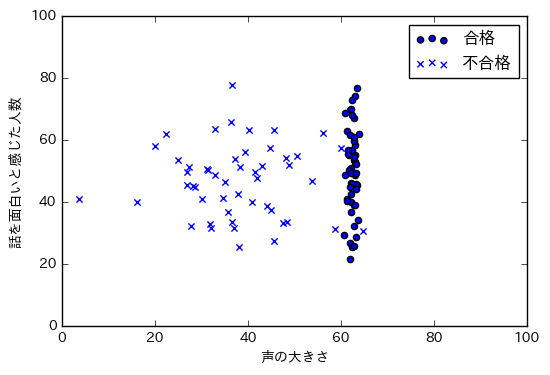

In [18]:
plotData(X,y)

### 目的関数
ロジスティック回帰の目的関数$J(\boldsymbol{\theta})$を、以下に示します。
$$J(\boldsymbol{\theta}) = -\frac{1}{m}\sum^{m}_{i=1}\left(y^{(i)}\log(h_{\boldsymbol{\theta}}(\boldsymbol{x}^{(i)}))+(1-y^{(i)})\log(1-h_{\theta}(\boldsymbol{x}^{(i)}))\right)$$
また、仮説$h_{\boldsymbol{\theta}}(x)$は、
$$h_{\boldsymbol{\theta}}(x^{(i)})=\frac{1}{1+e^{-\boldsymbol{\theta}^{\top}\boldsymbol{x^{(i)}}}}$$
<br>
とします。これから目的関数$J(\boldsymbol{\theta})$を計算するコードを書いていきます。

その下準備として、まず訓練例の数を`m`、特徴の数を`n`に格納しておきましょう。

In [19]:
m, n = X.shape

格納したデータの数を確認しましょう。

In [20]:
print("訓練例の数m：{}".format(m))
print("特徴の数n：{}".format(n))

訓練例の数m：100
特徴の数n：2


また、$\boldsymbol{\theta}$の初期値を`initial_theta`に格納しておきます。

（生成された`initial_theta`のshapeを確認しましょう。それを見て、１次元になっていることを確認して下さい。）

In [21]:
initial_theta = np.zeros(n+1) # フィッティングパラメータの初期値は全部ゼロ

In [22]:
initial_theta.shape

(3,)

**【課題９】** 仮説$h(\theta)$を計算する関数`hypothesis(X, theta)`を実装しましょう。
<br><br>
シグモイド関数はnumpyの数学関数を用いてもよいですし、scipyにすでに実装されている`scipy.special.expit(x)`を用いてもよいです。

$$h_{\boldsymbol{\theta}}(x^{(i)})=\frac{1}{1+e^{-\boldsymbol{\theta}^{\top}\boldsymbol{x^{(i)}}}}$$

参考：
- [numpyチュートリアル numpy.exp](http://docs.scipy.org/doc/numpy/reference/generated/numpy.exp.html)
- [scipyチュートリアル scipy.special.expit](http://docs.scipy.org/doc/scipy/reference/generated/scipy.special.expit.html)

**【Note】**

$\theta$と$x$の演算は**配列**によって転置が不要の場合や$-x^{(i)\top}\theta$のように入れ替わることもあります。データの配列には注意をしましょう。

In [32]:
#Coursemale-02 Step3 QuestionNumber9 1ac53ac5395d8be35cf381921783bc01
def hypothesis(X, theta):
    m = X.shape[0] #訓練例の数
    XwithBias = np.c_[np.ones([m,1]),X] # Xの1列目にズラッと1を並べる XwithBias.shapeは(100, 3)
###############ここを穴埋めしてください###############
    #numpyを使ってもscipyを使っても構いません。
    h = ss.expit(np.dot(XwithBias, theta))
######################################################
    return h

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [33]:
%%bash
./validation_client.py male-02 3 9 Step3_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



いま定義した仮説** hypothesis ** に入力データ X と初期化した$\theta$ initial_thetaを渡し実行してみます。

In [34]:
hypothesis(X, initial_theta)

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

** initial_theta ** を0に初期化していたため、シグモイド関数分母の${-\boldsymbol{\theta}^{\top}\boldsymbol{x^{(i)}}}$の計算結果はすべて0で$e^0$は1になります。よって ** hypothesis(X, initial_theta) ** の結果はすべて0.5になりました。シグモイド関数への入力値が0のとき、出力値が0.5となっていたことを思い出しましょう。下のセルを実行するとシグモイド関数のグラフが出力されます。

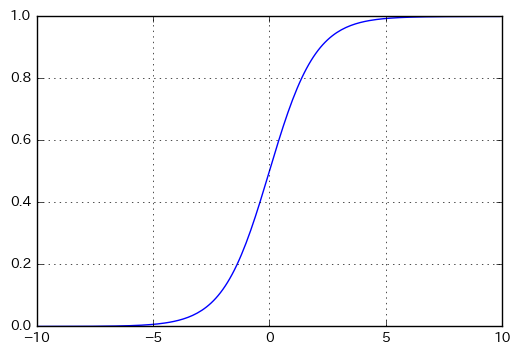

In [35]:
test_data = np.arange(-10,10,0.1)
h = ss.expit(test_data)
plt.plot(test_data, h)
plt.grid()
plt.show()

では次に、目的関数$J(\boldsymbol{\theta})$を計算する関数`cost(theta, X, y)`を書きましょう。

**【課題１０】** 目的関数$J(\boldsymbol{\theta})$を計算する関数`cost(theta, X, y)`を実装してください。
<br>

$$J(\boldsymbol{\theta}) = -\frac{1}{m}\sum^{m}_{i=1}\left(y^{(i)}\log(h_{\boldsymbol{\theta}}(\boldsymbol{x}^{(i)}))+(1-y^{(i)})\log(1-h_{\theta}(\boldsymbol{x}^{(i)}))\right)$$

** ヒント： **
- $h_{\boldsymbol{\theta}}(\boldsymbol{x}^{(i)})$は課題９で定義した関数hypothesis() を使うことができます。
- logはnumpyの数学関数 np.log(x) を使うことができます。

In [36]:
#Coursemale-02 Step3 QuestionNumber10 7aa86d7c7cc562504ad4efb61447425c
def cost(theta, X, y):
    h = hypothesis(X, theta) #仮説h
    m = X.shape[0] #訓練例の数

###############ここを穴埋めしてください###############
    # 1次元のnumpy配列同士のdot積は内積を表します。
    J = - (y.dot(np.log(h))+(1- y).dot(np.log(1- h))) / m 
######################################################

    # -inf * 0 は nan になる。そのときはJ全体をinfで返す。
    if np.isnan(J):
        return np.inf
    return J

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [37]:
%%bash
./validation_client.py male-02 3 10 Step3_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



いま実装した目的関数を用いて下のセルを実行し、初期のパラメータ（initial_theta）に対してのコストを出力してみましょう。

In [38]:
cost(initial_theta, X, y)

0.6931471805599453

この目的関数を利用して次に実装する目的関数の勾配で最適化をおこないます。最適化を行うことで目的関数の出力の値をなるべく小さくすることが目標になります。

### 目的関数の勾配(gradient)
目的関数$J(\boldsymbol{\theta})$の最小化（最適化）には、主に勾配(gradient)$\frac{\partial}{\partial \boldsymbol{\theta}}J(\boldsymbol{\theta})$を用いたアルゴリズムである勾配法が用いられます。一口に勾配法といっても実に様々な種類のアルゴリズムが発明されており、その中でも特に原始的かつ基本的なのがStep2の課題で実装した最急降下法です。

機械学習で主に用いられる最適化アルゴリズムは勾配法であるため、勾配$\frac{\partial}{\partial \boldsymbol{\theta}}J(\boldsymbol{\theta})$の実装は多くの場合必要になってきます。勾配を目的関数$J(\boldsymbol{\theta})$からソフトウェアで導出する手法は、講義で説明したように主に３種類ありますが、今回は手動で実装します。

ロジスティック回帰の目的関数の勾配は、以下のように計算されました。
$$\frac{\partial}{\partial \theta_j}J(\boldsymbol{\theta})=\frac{1}{m}\sum_{i=1}^{m}(h_{\boldsymbol{\theta}}(x^{(i)})-y^{(i)})x^{(i)}$$
これを実装すれば良いわけです。

**【課題１１】** 目的関数の勾配を計算する関数`grad(theta, X, y)`を実装しましょう。以下に、その一部がすでに書き込まれていますので、穴埋めしてください。

In [39]:
#Coursemale-02 Step3 QuestionNumber11 bce4b6146153b88e14aa53310640d18a
def grad(theta, X, y):
    m = X.shape[0] #訓練例の数
    XwithBias = np.c_[np.ones([m,1]),X] # Xの1列目にズラッと1を並べる XwithBias.shapeは(100, 3)
    h = hypothesis(X, theta) #仮説h 

###############ここを穴埋めしてください###############
    # ヒント：XwithBiasを使います。この行列の転置はXwithBias.T
    grad =  XwithBias.T.dot(h - y) / m
######################################################

    return grad

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [40]:
%%bash
./validation_client.py male-02 3 11 Step3_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



In [41]:
grad(initial_theta, X, y)

array([ 0.        , -6.16797212, -0.80155118])

以上を使って勾配法の繰り返しを行う前の状態を表示させておきます。

In [42]:
cost_init = cost(initial_theta, X, y)
grad_init = grad(initial_theta, X, y)
print("初期のθ（全部ゼロ）でのJの値(cost)は: ", cost_init)
print("初期のθ（全部ゼロ）でのJの勾配(grad)は：", grad_init)

初期のθ（全部ゼロ）でのJの値(cost)は:  0.6931471805599453
初期のθ（全部ゼロ）でのJの勾配(grad)は： [ 0.         -6.16797212 -0.80155118]


### 勾配法による最適化
Step2の課題では最急降下法を自力で実装し、それを目的関数の最適化アルゴリズムとして用いました。今回は、その他のアドバンストな勾配法アルゴリズムを用いたいと思います。すでにカリカリにチューニングされたアルゴリズムが沢山SciPyに揃っています。

[SciPy チュートリアル Optimization (scipy.optimize)](http://docs.scipy.org/doc/scipy/reference/optimize.html#optimization)

今回は1970年代後半に発明されたBFGSアルゴリズム(Broyden-Fletcher-Goldfarb-Shanno algorithm)を用いたいと思います。以下で出てくる`jac`は目的関数$J(\boldsymbol{\theta})$のヤコビアン(Jacobian)、つまり勾配(gradient)のことです。

次を実行すると、赤い欄で「RuntimeWarning: divide by zero encountered in log」と警告(Warning)されることがあります、これは`cost(theta, X, y)`関数で使われている`np.log(x)`に関する警告です。$\log(0)$が未定義であるため、何かが変だと警告してくれているのです。$$\lim_{x \rightarrow 0}\log(x) = -\infty$$であるため、`np.log(0)`を実行すると便宜的に`-inf`を返しておいてくれますが、数学的に正しくは未定義（$\log(0)$に該当する数は存在しない）であり、また$-\infty$でもありません。この対策は`cost(theta, X, y)`関数の最後の方で行っていますので、警告が出てもとりあえず大丈夫です。もし気になる場合は`cost(theta, X, y)`関数を、logの内部(`h`と`1-h`)が1の時、0の時とそれぞれ場合分けして対策すればいいでしょう。

In [43]:
res = scopt.minimize(cost, initial_theta, jac=grad, args=(X,y), method='BFGS', options={'maxiter': 400, 'disp': True})

Optimization terminated successfully.
         Current function value: 0.094398
         Iterations: 32
         Function evaluations: 40
         Gradient evaluations: 36


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


ここで、[SciPy公式チュートリアル scipy.optimize.minimize](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)を読むと、minimize関数に出てくるオプションの一つである`jac`はoptional、つまりあってもなくてもよいオプションであると書いてあります。これは変だと思いませんか。BFGSは勾配法の一種であり、勾配法には勾配の計算が不可欠でした。一体どうなっているのでしょうか。

もう少しチュートリアルをよく読んで下さい。`jac`デフォルトでは`None`つまり`False`であり、`jac=False`のとき数値的に概算する（数値微分）と書いてあります。オプションを指定しないと数値微分によって勾配が求められるのです。数値微分は大変計算量が大きいですから、大規模な学習を行う場合は避けなければなりません。

では、BFGSによって最適化した結果を出力しましょう。今回の実装では、
- res.fun："cost"の最適化された結果を返す
- res.x："initial_theta"の最適化された結果を返す

In [44]:
J = res.fun
theta = res.x

学習がうまく進んでいると目的関数の出力である** Jの値(cost) ** が０に限りなく近づいているはずです。下のセルを実行してください。

In [45]:
print("最小化されたJの値(cost)は: ", J)
print("そのときのthetaは：", theta)

最小化されたJの値(cost)は:  0.09439758661348485
そのときのthetaは： [-6.21712319e+01  1.01878488e+00  4.25811876e-02]


最適化されたシータの値をそれぞれ改めて確認してみます。

In [46]:
#θ0の値
theta[0]

-62.1712319380802

In [47]:
#θ1の値
theta[1]

1.0187848782858968

In [48]:
#θ2の値
theta[2]

0.04258118762822235

### 決定境界
この目的関数を最小化した結果を用いて、決定境界(Decision Boundary)を引いてみましょう。

**【課題１２】** 決定境界を引く関数`plotDataWithDB(X, y, theta)`を実装しましょう。以下に、その一部がすでに書き込まれていますので、穴埋めしてください。

ヒント：$$\theta_0+\theta_1x_1+\theta_2x_2 = 0$$を式変形すると、$$x_2=-\frac{\theta_0+\theta_1x_1}{\theta_2}$$となることを利用します。

In [49]:
#Coursemale-02 Step3 QuestionNumber12 156c0583d8529d22a87bf16e771e7309
def plotDataWithDB(X, y, theta):
    #課題8で実装してもらった関数です
    plotData(X,y)
    
    #このセル内で直前にプロットしたものに上書きしていきます
    plt.hold(True)
    
    #得られたthetaをもとにグラフの画面の端と端(0,100)をプロットしてその間に直線で引くことで、回帰直線を掃引します。
###############ここを穴埋めしてください###############
    x1_plot = np.array([0, 100])
    x2_plot = - ( theta[0] + theta[1] * x1_plot) / theta[2]
    plt.plot(x1_plot, x2_plot)
######################################################
    
    #念のため、グラフの端をもう一度指定しておきます。
    plt.xlim([0,100])
    plt.ylim([0,100])
    
    #凡例を入れます。
    plt.legend((u'決定境界', u'合格', u'不合格'))
    
    plt.show()

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [50]:
%%bash
./validation_client.py male-02 3 12 Step3_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



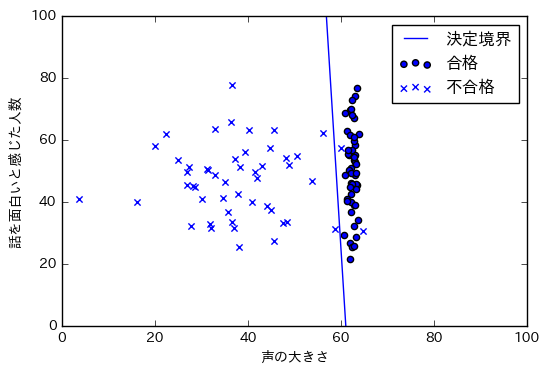

In [51]:
plotDataWithDB(X, y, theta)

### 訓練集合に入っていないデータからの予測
訓練集合に入っていないデータから予測します。

**【課題１３】** 声の大きさが45点、話を面白いと感じた人数が85人の候補者が合格する確率はいくつになるでしょうか。

** ヒント：** 
- ロジスティック回帰では仮説の出力は何を意味していたでしょうか。<br>
- 学習済みのパラメータ** theta ** を使います。
- 入力Xは、「声の大きさが45点、話を面白いと感じた人数が85人」を２次元配列で渡すことに注意しましょう。

In [52]:
#Coursemale-02 Step3 QuestionNumber13 8bc7aa1be097266bfa4a55a48731f581
###############ここを穴埋めしてください###############
prob = hypothesis(np.array([[45, 85]]), theta)
######################################################
print("声の大きさが45点、話を面白いと感じた人数が85人の候補者が合格する確率は", prob[0])

声の大きさが45点、話を面白いと感じた人数が85人の候補者が合格する確率は 3.031313608800768e-06


左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [53]:
%%bash
./validation_client.py male-02 3 13 Step3_02.ipynb api.internal.zero2one.jp

声の大きさが45点、話を面白いと感じた人数が85人の候補者が合格する確率は 3.0313136088006925e-06
Congratulations!
We give you 10 points out of 10 points.



### 訓練集合に対する予測精度
訓練データに対する予測精度を計算します。下のセルにはすでに訓練データと目標変数を用いてモデルの精度を予測する関数を実装しているのでそのままセルを実行してみてください。以下のコードは精度を測定する際によく使うので保存しておくといいでしょう。

In [54]:
def predict(theta, X):
    h = hypothesis(X, theta)
    predicted_y = np.where(h >= 0.5, 1, 0 )
    return predicted_y

In [55]:
predictX = predict(theta, X)
accuracy = (predictX == y).mean()
print("学習精度は %2.1f"% (accuracy*100), "%")

学習精度は 98.0 %


---
## 多項式で特徴を拡張したロジスティック回帰

ここからは別の訓練集合を使って学習モデルの学習をさせていきます。次に新たに生成するデータセットは直線での分類が難しい** 線形分離不可能なデータ **を取り扱っていきます。

### サンプルデータを生成

今回の演習では、事前に用意したデータセットを使ってロジスティック回帰の実装を行います。下のセルを実行するとデータセットが読み込まれます。一度生成したら同じものを毎回使えるように、データをCSVファイル(Comma-Separated Values コンマで区切られたデータ)で保存しておきます。
<br><br>
** Note： **新たなデータを使いたいときは、CSVファイルの名前を変えるか、コードを変えましょう。

In [56]:
if not os.path.isdir("./dataStep3"):
    os.makedirs("./dataStep3")

if os.path.isfile("./dataStep3/dataStep3_2.csv") == True:
    data = np.loadtxt("./dataStep3/dataStep3_2.csv", delimiter = ",")
    X = data[:,0:2]  # X.shapeは(100, 2)
    y = data[:,2] #y.shapeは(100, ) 1-dimのndarrayにしておく（縦ベクトルにならないこと注意）

else:
    X, y = datasets.make_circles(n_samples=120, factor = 0.6, noise = 0.1)
    X = X + 1.5 # -1.5から1.5くらいから0から3くらいに変える
    np.savetxt("./dataStep3/dataStep3_2.csv", np.c_[X, y], delimiter=",", fmt="%f,%f,%d")

上のセルを実行したことによりデータセットを "data" に格納しました。下のセルを実行して、dataのshapeを確認しましょう。

In [57]:
data.shape

(120, 3)

(120,3)と表示されたはずです。
<br>
<br>
今回使うデータセットは120行3列の行列がdataに格納されています。そしてXにdataの2列目までのデータセットを格納し、yにdataの3列目のデータを格納しています。下のセルを実行して、格納したdataの中身の一部分を確認してみましょう。

部分的にdataの中身を確認する方法を知っていると便利です。下のセルを実行してみてください。

In [58]:
data[:5]

array([[1.907017, 0.42823 , 0.      ],
       [2.365571, 0.837132, 0.      ],
       [1.020166, 1.089013, 1.      ],
       [0.897959, 1.653931, 1.      ],
       [1.910298, 1.183538, 1.      ]])

In [59]:
data[:5,0][:,np.newaxis]

array([[1.907017],
       [2.365571],
       [1.020166],
       [0.897959],
       [1.910298]])

In [60]:
data[:5,1][:,np.newaxis]

array([[0.42823 ],
       [0.837132],
       [1.089013],
       [1.653931],
       [1.183538]])

In [61]:
data[:5,2][:,np.newaxis]

array([[0.],
       [0.],
       [1.],
       [1.],
       [1.]])

実際に** X **と ** y ** のデータを確認しておきましょう。

In [62]:
X.shape

(120, 2)

In [63]:
y.shape

(120,)

- ** X ** は訓練データ
- ** y ** は目標変数

## データセットの可視化

### 生成したデータの表示

可視化は機械学習の実装において大変重要な作業になります。開発を進める前にデータセットの性質を把握し、可視化する癖をつけておきましょう。

今回生成したデータセットの横軸は「甘さ」、縦軸は「辛さ」とします。

**【課題１４】** 可視化する関数plotData2(X, y)を書きましょう。横軸・縦軸は共に0から3のレンジになるようにしましょう。

** Note： **
- xlim と ylim で目盛りの幅を固定
- xlabel と ylabel で横軸縦軸の凡例を記入

参考：[matplotlib.pyplot 公式チュートリアル](http://matplotlib.org/api/pyplot_api.html)

In [65]:
#Coursemale-02 Step3 QuestionNumber14 4c0372952c4b60b43100512033b335b6
def plotData2(X, y):
###############ここを穴埋めしてください###############
    plt.scatter(X[y==1,0], X[y==1,1], marker='o')
    plt.scatter(X[y==0,0], X[y==0,1], marker='x')
    plt.xlim([0,3])
    plt.ylim([0,3])
    plt.xlabel(u"甘さ")
    plt.ylabel(u"辛さ")
    plt.legend((u'y=1',u'y=0'))
    plt.draw()   

######################################################

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [66]:
%%bash
./validation_client.py male-02 3 14 Step3_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



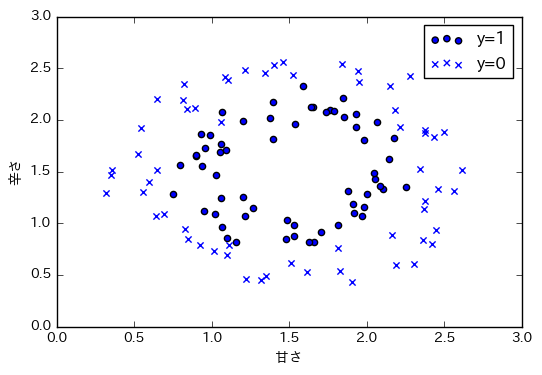

In [67]:
plotData2(X, y)

### 多項式で特徴を増やす
プロットしたグラフを見たら分かるように、このデータは直線ではy=0とy=1を分離できなさそうです。多項式で特徴を増やしましょう。

In [68]:
def polyFeature(X0, X1, degree):
    X0 = X0[:, np.newaxis] #np.appendで付け足していくため、2-dimにする
    X1 = X1[:, np.newaxis]
    Xpoly = np.empty((X0.shape[0], 0)) # m行0列の配列を作成。これに新たな特徴を付け足していく。

    for i in range(1, degree+1):
        for j in range(i+1):
            Xpoly = np.append(Xpoly, ((X0**(i-j)) * (X1**j)), axis=1)

    return Xpoly

次数は10次にします。

In [69]:
deg = 10 #次数10次

In [70]:
Xpoly = polyFeature(X[:,0], X[:,1], deg)

このとき、特徴の数はいくつになるでしょうか。考えてみましょう。答えは`Xpoly.shape[1]`で確認しましょう。

In [71]:
Xpoly.shape[1]

65

### 学習
目的関数を最適化しましょう。

**【課題１５】** 目的関数を最適化しましょう。これまで作った関数 cost(theta, X, y)`と`grad(theta, X, y)`は特徴の数が増えても対応できるようになっています。（`cost(theta, X, y)`と`grad(theta, X, y)`のコードを読み直して、今回のケースでもそのまま流用できることを改めて理解しましょう）
<br><br>
** ヒント： **
- 「** 勾配法による最適化 **」で行なったSciPyの最適化アルゴリズムを使います。
- 最適化するパラメータθの初期値：initial_thetaPoly
- argsには Xpoly と y を渡します。

In [76]:
#Coursemale-02 Step3 QuestionNumber15 ac63d61e18c07b936244df0ba23ad032
m, nPoly = Xpoly.shape #訓練例の数はm個, 特徴の数はn個
initial_thetaPoly = np.zeros(nPoly+1) # フィッティングパラメータの初期値は全部ゼロ 1-dimのndarray
###############ここを穴埋めしてください###############
res = scopt.minimize(cost, initial_thetaPoly, jac=grad, args=(Xpoly, y), method='BFGS', options={'maxiter': 400, 'disp': True})
######################################################

         Current function value: 0.078389
         Iterations: 33
         Function evaluations: 85
         Gradient evaluations: 59


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [77]:
%%bash
./validation_client.py male-02 3 15 Step3_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



学習結果を出力しましょう。

In [78]:
Jpoly = res.fun
thetaPoly = res.x
print("最小化されたJの値(cost)は: ", Jpoly)
print("そのときのthetaは：", thetaPoly)

最小化されたJの値(cost)は:  0.07838944854896154
そのときのthetaは： [-2.18259965 -1.45206272 -1.1259988  -1.06081502 -0.25327679 -0.46711944
 -0.81019515  0.22566037  0.43206291 -0.07355646 -0.60113765  0.56037003
  0.81568601  0.77052879  0.09446636 -0.38626283  0.84388554  0.98997006
  0.93491413  0.82110277  0.03547046 -0.16818437  1.05925235  1.03121754
  0.81434673  0.70140194  0.61256591 -0.22580902 -0.02321529  1.06682854
  0.86104739  0.49446079  0.28540223  0.24648014  0.23630681 -0.52571689
 -0.10693262  0.61507826  0.31206428 -0.075631   -0.2557912  -0.26182724
 -0.16809044 -0.04858016 -0.44783735 -0.44579739 -0.36338908 -0.51859892
 -0.72943814 -0.72592355 -0.55826012 -0.34663563 -0.14783399  0.10083622
  0.39578079  0.24803674 -0.24184167  0.29134208  0.2838865   0.16172521
  0.10847806  0.13997251  0.1834168   0.10739252 -0.1280487  -0.03833563]


### 決定境界
決定境界を引く関数`plotDataWithDB2(X, y, theta, deg)`を作ります。今回は複雑な曲線であるため、これまでのように端と端を計算してplotし直線を引くという手法が使えません。どうすればよいでしょうか。

ここで使う手法はよく使われるので、是非コードを熟読して下さい。

In [79]:
def plotDataWithDB2(X, y, theta, deg):
    #課題８で実装してもらった関数です
    plotData2(X,y)
    
    #このセル内で直前にプロットしたものに上書きしていきます
    plt.hold(True)
    
    #横軸も縦軸も0から3まで、均等に50サンプル取ってきます。
    X0_lin = np.linspace(0, 3, 50)
    X1_lin = np.linspace(0, 3, 50)
    
    #そしてこの50×50=2500個の地点におけるx(バイアス込み)とthetaの内積をそれぞれ計算してきます。
    y_plot = np.empty((X0_lin.size, X1_lin.size))
    
    for i in range(X0_lin.size):
        for j in range(X1_lin.size):
            y_plot[i, j] = np.c_[[1], polyFeature( np.array([X0_lin[i]]), np.array([X1_lin[j]]), deg)].dot(theta)
    
    #この2500個のサンプルに対して、等高線を引きます。値がゼロのところが決定境界ですので、levels=[0]のみ等高線を引きます。
    plt.contour(X0_lin, X1_lin, y_plot.T, levels=[0])
    
    #念のため、グラフのレンジをもう一度指定しておきます。
    plt.xlim([0,3])
    plt.ylim([0,3])
    
    plt.show()

あとは実行するだけです。多少描画に時間がかかるかもしれません。

/opt/conda/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/opt/conda/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


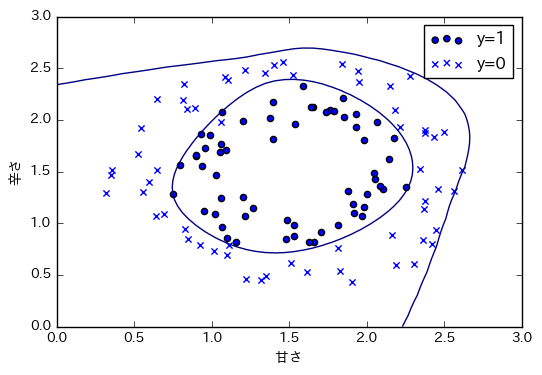

In [80]:
plotDataWithDB2(X, y, thetaPoly, deg)

### 訓練集合に対する予測精度
最後に、訓練集合に対する予測精度を計算しましょう。

**【課題１６】** 訓練集合に対する予測精度を計算しましょう。先ほど作った`predict(theta, X)`は今回のケースでもそのまま使えます。余力のある人は当該コードを読み直しましょう。
<br><br>
** ヒント： **
- predict()には、thetaPoly と Xpolyを渡し、変数predictXpolyに格納します。
- accuracyPolyは predictXpoly を使って求めた正解率を格納します。

In [81]:
#Coursemale-02 Step3 QuestionNumber16 4a8919725b23e66165d012c1f3319d5e
###############ここを穴埋めしてください###############
predictXpoly = predict(thetaPoly, Xpoly)
accuracyPoly = (predictXpoly == y).mean()
######################################################
print("学習精度は %2.1f"% (accuracyPoly*100), "%")

学習精度は 99.2 %


左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [82]:
%%bash
./validation_client.py male-02 3 16 Step3_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



---
## L2正則化（Ridge回帰）


先ほどプロットした決定境界をもう一度よく見て下さい。たしかに訓練集合に対してうまくフィッティングできていますが、妙なところに決定境界があったりします。この決定境界はさすがに何だか変です。この図の中に新たな例をプロットしたとしましょう。その新たな地点に関して上手く予測できると思いますか。変な予測をしそうなところが沢山あると思います。つまりオーバーフィッティングしてしまっているのです。

L2正則化を行い、オーバーフィッティング対策を行いましょう。

### 目的関数とその勾配

L2正則化は、目的関数を以下のように変えれば良いのでした。
$$J(\boldsymbol{\theta}) = J_{\mathrm{original}}(\boldsymbol{\theta}) + \frac{\lambda}{2m}\sum^{n}_{j=1}\theta_j^2 $$
ここでいう$J_{\mathrm{original}}(\boldsymbol{\theta})$とは、元々の目的関数のことです。これに、正則化項$\frac{\lambda}{2m}\sum^{n}_{j=1}\theta_j^2$を付け足せば、正則化が行えます。
また正則化したとき、目的関数の勾配は
$$\frac{\partial}{\partial \theta_j}J(\boldsymbol{\theta}) =\begin{cases} \frac{\partial}{\partial \theta_0}J_{\mathrm{original}}(\boldsymbol{\theta}) &\mathrm{if}\;\;j=0\\
\frac{\partial}{\partial \theta_j}J_{\mathrm{original}}(\boldsymbol{\theta}) + \frac{\lambda}{m}\theta_j \;\;&\mathrm{if}\;\;j\neq0 \end{cases}$$
となります。ではこれを実装しましょう。

In [83]:
#正則化された目的関数
def costReg(theta, X, y, lmd):
    m = y.size
    J = cost(theta, X, y)

    J = J + lmd * np.square(np.linalg.norm(theta[1:])) / (2 * m)

    return J

**【課題１７】** 正則化された目的関数の勾配を計算する関数`gradReg(theta, X, y, lmd)`を書きましょう。以下に、その一部がすでに書き込まれていますので、穴埋めしてください。

In [84]:
#Coursemale-02 Step3 QuestionNumber17 d0f633d12e2903afd1ca206ba44668a6
def gradReg(theta, X, y, lmd):
    m = y.size
    g = grad(theta, X, y)
    theta[0] = 0 #0番目の成分は正則化項に含めないため、0にしておきます。
    
###############ここを穴埋めしてください###############
    g = g + lmd * theta / m
######################################################

    return g

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [85]:
%%bash
./validation_client.py male-02 3 17 Step3_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



正則化パラメータはとりあえず100にします。pythonでは「lambda」はラムダ式を意味するので、変数の名前には使えません。`lmd`などを利用しましょう。一通り課題を終えたら正則化パラメータ`lmd`を色々変えてみましょう。

In [86]:
lmd = 100

書いた関数が走るかどうか調べるため、$\boldsymbol{\theta}$の初期値に対して目的関数とその勾配を計算してみましょう。本当に正しい値が出力されているかどうかはこれだけでは不明ですが、走らなかったらどこかがおかしいということになります。

In [87]:
cost_initReg = costReg(initial_thetaPoly, Xpoly, y, lmd)
grad_initReg = gradReg(initial_thetaPoly, Xpoly, y, lmd)


print("初期のθ（全部ゼロ）でのJの値(cost)は: ",end="")
print(cost_initReg)
print("初期のθ（全部ゼロ）でのJの勾配(grad)は：")
print(grad_initReg)

初期のθ（全部ゼロ）でのJの値(cost)は: 0.6931471805599453
初期のθ（全部ゼロ）でのJの勾配(grad)は：
[ 0.00000000e+00  6.53983333e-04 -4.74871250e-03  8.33901706e-02
 -1.48424544e-02  5.84353159e-02  3.74446622e-01  8.50324912e-02
  6.61168729e-02  2.94514446e-01  1.21771750e+00  4.67513802e-01
  2.67830999e-01  3.91948981e-01  9.91933533e-01  3.50350010e+00
  1.60909432e+00  9.56130553e-01  8.89461376e-01  1.37599019e+00
  2.90618173e+00  9.49616826e+00  4.75218297e+00  2.92106432e+00
  2.35407719e+00  2.65051214e+00  4.11027012e+00  7.97996323e+00
  2.49007311e+01  1.30715148e+01  8.19481458e+00  6.26191040e+00
  6.00215251e+00  7.37547372e+00  1.14233156e+01  2.11584345e+01
  6.40054945e+01  3.45922593e+01  2.19160365e+01  1.63218097e+01
  1.44047855e+01  1.53006750e+01  1.97457778e+01  3.05617887e+01
  5.49458758e+01  1.62456943e+02  8.94634018e+01  5.69626706e+01
  4.17426866e+01  3.51404550e+01  3.41794635e+01  3.88091660e+01
  5.16795591e+01  7.99567084e+01  1.40812812e+02  4.08964274e+02
  2.28050241e+02  1.45

### 学習
正則化された目的関数を最適化しましょう。

**【課題１８】** 正則化された目的関数を最適化しましょう。

** Note： **
- 「** 勾配法による最適化 **」で行なったSciPyの最適化アルゴリズムを使います。
- 目的関数：costReg
- 最適化するパラメータθの初期値：initial_thetaPoly
- 目的関数の勾配：gradReg
- args：Xpoly,y,lmdを渡す

In [92]:
#Coursemale-02 Step3 QuestionNumber18 e395fd666672f5aa247931fde5e99011
###############ここを穴埋めしてください###############
res = scopt.minimize(costReg, initial_thetaPoly, jac=gradReg, args=(Xpoly,y,lmd), method='BFGS', options={'maxiter': 400, 'disp': True})
######################################################

Optimization terminated successfully.
         Current function value: 0.177332
         Iterations: 109
         Function evaluations: 127
         Gradient evaluations: 118


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log


左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [93]:
%%bash
./validation_client.py male-02 3 18 Step3_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



In [94]:
Jreg = res.fun
thetaReg = res.x
print("最小化されたJの値(cost)は: ", Jreg)
print("そのときのthetaは：", thetaReg)

最小化されたJの値(cost)は:  0.17733167648402542
そのときのthetaは： [-1.41021660e+00  7.03413787e-03  8.97486768e-03  9.79243983e-03
  1.96757766e-02  1.43792285e-02  1.02327632e-02  2.57249576e-02
  2.80746681e-02  1.76013455e-02  9.03666395e-03  3.02617912e-02
  3.56441012e-02  3.41921447e-02  1.88200958e-02  6.32114191e-03
  3.48334737e-02  4.13446247e-02  4.19932131e-02  3.84609413e-02
  1.72021545e-02  1.94742460e-03  4.03096046e-02  4.69447747e-02
  4.64234757e-02  4.51466380e-02  4.01088693e-02  1.09554132e-02
 -4.25907606e-03  4.69640129e-02  5.24904706e-02  4.86674719e-02
  4.55571361e-02  4.39171851e-02  3.73565684e-02 -2.15094131e-03
 -1.22623696e-02  5.36545552e-02  5.51508522e-02  4.56764790e-02
  3.90417095e-02  3.67104703e-02  3.60406524e-02  2.83433596e-02
 -2.22156632e-02 -2.16825661e-02  5.49946270e-02  4.49710394e-02
  2.60162723e-02  1.57175588e-02  1.39484042e-02  1.67705194e-02
  1.99503079e-02  1.49395382e-02 -3.83344721e-02 -3.27648266e-02
  3.32180399e-02 -6.54093388e-03 -4.20

### 決定境界
この結果をもとに決定境界を掃引しましょう。

**【課題１９】** 決定境界を`plotDataWithDB2(X, y, theta, deg)`を使って描画しましょう。

/opt/conda/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/opt/conda/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


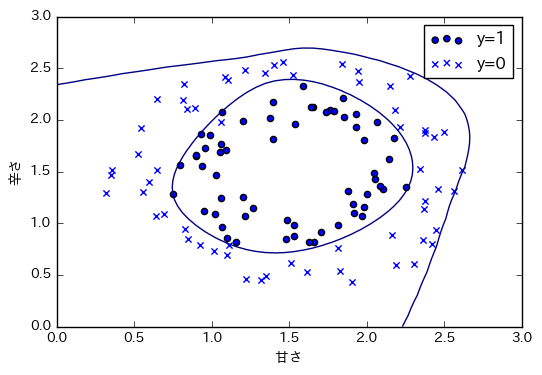

In [96]:
#Coursemale-02 Step3 QuestionNumber19 e0c9780aff7f73ea9b5cd8ce25906726
###############ここを穴埋めしてください###############
plotDataWithDB2(Xpoly, y, thetaPoly, deg)
######################################################

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [97]:
%%bash
./validation_client.py male-02 3 19 Step3_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



多少決定境界からはみ出てしまった訓練例がありますが、違和感のある決定境界は少なくとも描画した範囲内ではなくなっていることが分かります。これならば、新しいデータに対しても妥当な推測を行えそうです。

### 訓練集合に対する予測精度
最後に、訓練集合に対する予測精度を計算しましょう。

**【課題２０】** 訓練集合に対する予測精度を計算しましょう。

In [99]:
#Coursemale-02 Step3 QuestionNumber20 547338cb5c4c1c3a0467c4d509f568c4
###############ここを穴埋めしてください###############
predictXreg = predict(thetaPoly, Xpoly)
accuracyReg = (predictXreg == y).mean()
######################################################
print("学習精度は %2.1f"% (accuracyReg*100), "%")

学習精度は 99.2 %


左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [100]:
%%bash
./validation_client.py male-02 3 20 Step3_02.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



学習精度は正則化しないときに比べて落ちていることが分かります。学習精度は、そのモデルがよりよく推測できるかどうかの指標として、単純には扱えないことが分かります。Step6で、この数字をいかに読み解くかということを、詳しく説明します。

---
## 終わりに
今回はロジスティック回帰の実装、多項式による特徴の拡張、正則化について実習しました。特に、正則化についてはよく体感的に把握していただきたいので、正則化パラメータを色々変えながらよく復習して下さい。

これらの実装はもちろんscikit-learnでも行われています。これは次のStepで扱います。